In [2]:
## 1. Environment Setup and Data Loading
# First, we'll load the necessary libraries and download the CI/CD dataset from the Ruby on Rails project.

# Import required libraries
import requests
import zipfile
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import lightgbm as lgb
import joblib
import json

# Set up visualization style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries loaded successfully!")


Libraries loaded successfully!


In [3]:
# Download the CI/CD dataset
print("Downloading Ruby on Rails CI/CD dataset...")
url = 'https://github.com/elbaum/CI-Datasets/raw/master/RailsCleanData.out.zip'
response = requests.get(url)
response.raise_for_status()

# Extract and load the data
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    file_name = z.namelist()[0]
    
    # Define column names based on dataset documentation
    column_names = [
        'Test Suite', 'Test Suite Start Time', 'Test Suite Duration',
        'Test Suite Runs', 'Test Suite Assertions', 'Test Suite Failures',
        'Test Suite Errors', 'Test Suite Skips', 'Build Number',
        'Build Pull Request', 'Commit Sha', 'Build State',
        'Build Start Time', 'Build Finish Time', 'Build Duration',
        'Job Id', 'Job Start Time', 'Job Allow Failure'
    ]
    
    # Load data with proper column names
    df = pd.read_csv(z.open(file_name), sep=';', header=None, names=column_names)

print(f"Dataset loaded: {df.shape[0]:,} rows and {df.shape[1]} columns")
print("\nFirst few rows:")
df.head()


Dataset loaded: 3,594,276 rows and 18 columns

First few rows:


,Test Suite,Test Suite Start Time,Test Suite Duration,Test Suite Runs,Test Suite Assertions,Test Suite Failures,Test Suite Errors,Test Suite Skips,Build Number,Build Pull Request,Commit Sha,Build State,Build Start Time,Build Finish Time,Build Duration,Job Id,Job Start Time,Job Allow Failure
0,railties/test/app_rails_loader_test.rb,2016-03-24 19:01:23.0,0.035011,16,20,0,0,0,33391,True,246c1248e5f5e38125898a72d21d4fe58e6182be,"passed,2016-03-24 19:01:23.0",2016-03-24 19:22:08.0,1245000.0,118308786,2016-03-24 18:42:35.0,False,NaN
1,railties/test/application/asset_debugging_test.rb,2016-03-24 19:01:23.0,17.408814,2,9,0,0,0,33391,True,246c1248e5f5e38125898a72d21d4fe58e6182be,"passed,2016-03-24 19:01:23.0",2016-03-24 19:22:08.0,1245000.0,118308786,2016-03-24 18:42:35.0,False,NaN
2,railties/test/backtrace_cleaner_test.rb,2016-03-24 19:01:40.0,162.113491,30,116,0,0,0,33391,True,246c1248e5f5e38125898a72d21d4fe58e6182be,"passed,2016-03-24 19:01:23.0",2016-03-24 19:22:08.0,1245000.0,118308786,2016-03-24 18:42:35.0,False,NaN
3,railties/test/code_statistics_calculator_test.rb,2016-03-24 19:04:22.0,41.402265,2,7,0,0,0,33391,True,246c1248e5f5e38125898a72d21d4fe58e6182be,"passed,2016-03-24 19:01:23.0",2016-03-24 19:22:08.0,1245000.0,118308786,2016-03-24 18:42:35.0,False,NaN
4,railties/test/engine_test.rb,2016-03-24 19:05:03.0,2.786692,1,6,0,0,0,33391,True,246c1248e5f5e38125898a72d21d4fe58e6182be,"passed,2016-03-24 19:01:23.0",2016-03-24 19:22:08.0,1245000.0,118308786,2016-03-24 18:42:35.0,False,NaN


In [4]:
## 2. Data Cleaning and Feature Engineering
# Now we'll clean the data and create features that can help predict pipeline duration.

# Clean column names
df.columns = df.columns.str.strip()

# Convert timestamp columns to datetime
time_columns = ['Test Suite Start Time', 'Build Start Time', 'Build Finish Time']
for col in time_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Remove extreme outliers (keep 99% of data)
duration_upper_bound = df['Test Suite Duration'].quantile(0.99)
initial_size = len(df)
df = df[df['Test Suite Duration'] < duration_upper_bound]
print(f"Removed {initial_size - len(df):,} outliers (top 1% of durations)")

# Extract time-based features
df['start_day_of_week'] = df['Test Suite Start Time'].dt.dayofweek  # 0=Monday, 6=Sunday
df['start_hour_of_day'] = df['Test Suite Start Time'].dt.hour       # 0-23

# Apply log transformation to reduce skewness in target variable
df['log_duration'] = np.log1p(df['Test Suite Duration'])

print("\nFeature engineering complete!")
print(f"Final dataset size: {len(df):,} rows")


Removed 35,943 outliers (top 1% of durations)

Feature engineering complete!
Final dataset size: 3,558,333 rows


Duration Statistics (in seconds):
count    3.558333e+06
mean     8.429412e+00
std      3.049998e+01
min      1.438390e-04
25%      5.468170e-02
50%      2.908430e-01
75%      1.632909e+00
max      2.926757e+02
Name: Test Suite Duration, dtype: float64


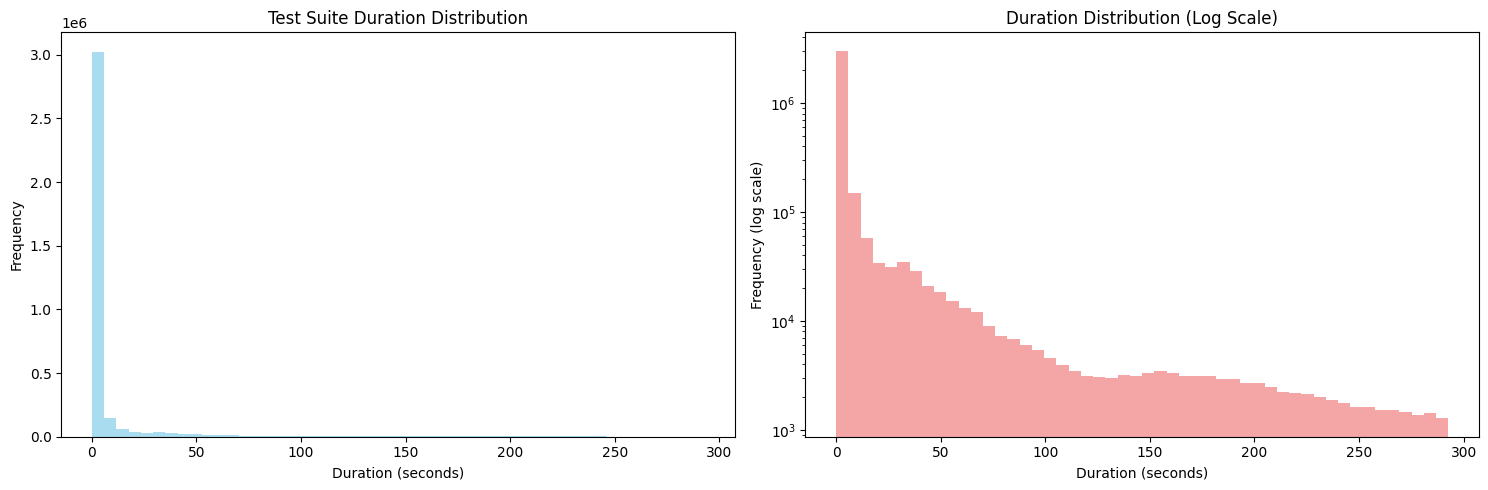

In [5]:
## 3. Exploratory Data Analysis
# Let's understand the patterns in our data before building the model.

# Basic statistics
print("Duration Statistics (in seconds):")
print(df['Test Suite Duration'].describe())

# Visualize duration distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Normal scale
ax1.hist(df['Test Suite Duration'], bins=50, alpha=0.7, color='skyblue')
ax1.set_title('Test Suite Duration Distribution')
ax1.set_xlabel('Duration (seconds)')
ax1.set_ylabel('Frequency')

# Log scale
ax2.hist(df['Test Suite Duration'], bins=50, alpha=0.7, color='lightcoral')
ax2.set_yscale('log')
ax2.set_title('Duration Distribution (Log Scale)')
ax2.set_xlabel('Duration (seconds)')
ax2.set_ylabel('Frequency (log scale)')

plt.tight_layout()
plt.show()


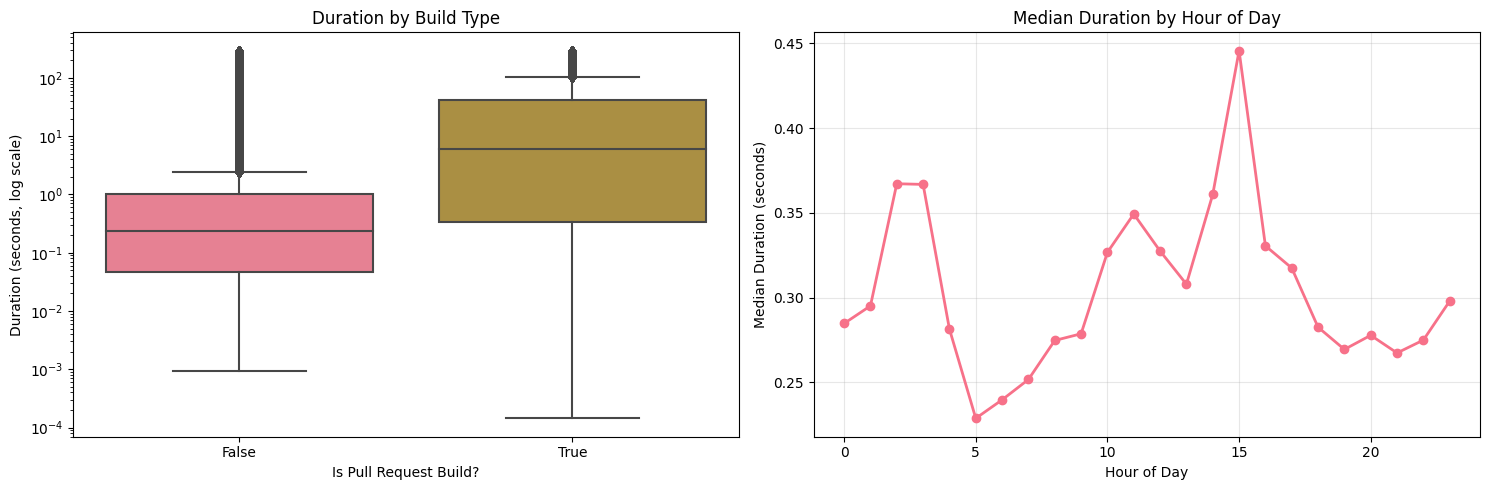

In [6]:
# Analyze patterns by build type and timing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Duration by build type (PR vs regular)
clean_data = df.dropna(subset=['Build Pull Request', 'Test Suite Duration'])
sns.boxplot(x='Build Pull Request', y='Test Suite Duration', data=clean_data, ax=ax1)
ax1.set_yscale('log')
ax1.set_title('Duration by Build Type')
ax1.set_xlabel('Is Pull Request Build?')
ax1.set_ylabel('Duration (seconds, log scale)')

# Duration by hour of day
hourly_avg = df.groupby('start_hour_of_day')['Test Suite Duration'].median()
ax2.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
ax2.set_title('Median Duration by Hour of Day')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Median Duration (seconds)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [7]:
## 4. Model Development
# We'll train a LightGBM model to predict pipeline durations using the engineered features.

# Prepare features and target for modeling
feature_columns = ['Build Pull Request', 'start_hour_of_day', 'start_day_of_week']
target_column = 'log_duration'

# Remove rows with missing values
model_data = df.dropna(subset=feature_columns + [target_column]).copy()
print(f"Clean data for modeling: {len(model_data):,} samples")

# Prepare features and target
X = model_data[feature_columns]
y = model_data[target_column]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train):,}")
print(f"Testing samples: {len(X_test):,}")


Clean data for modeling: 3,558,333 samples
Training samples: 2,846,666
Testing samples: 711,667


In [8]:
# Train the LightGBM model
print("Training LightGBM model...")

model = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbose=-1  # Suppress training output
)

model.fit(X_train, y_train)
print("Model training completed!")


Training LightGBM model...
Model training completed!


In [9]:
## 5. Model Evaluation
# Let's evaluate how well our model performs on the test set.

# Make predictions
y_pred_log = model.predict(X_test)

# Convert predictions back to original scale
y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print("=== Model Performance ===")
print(f"Mean Absolute Error: {mae:.2f} seconds")
print(f"R-squared Score: {r2:.3f}")
print(f"Average prediction error: ~{mae/60:.1f} minutes")


=== Model Performance ===
Mean Absolute Error: 8.40 seconds
R-squared Score: -0.002
Average prediction error: ~0.1 minutes


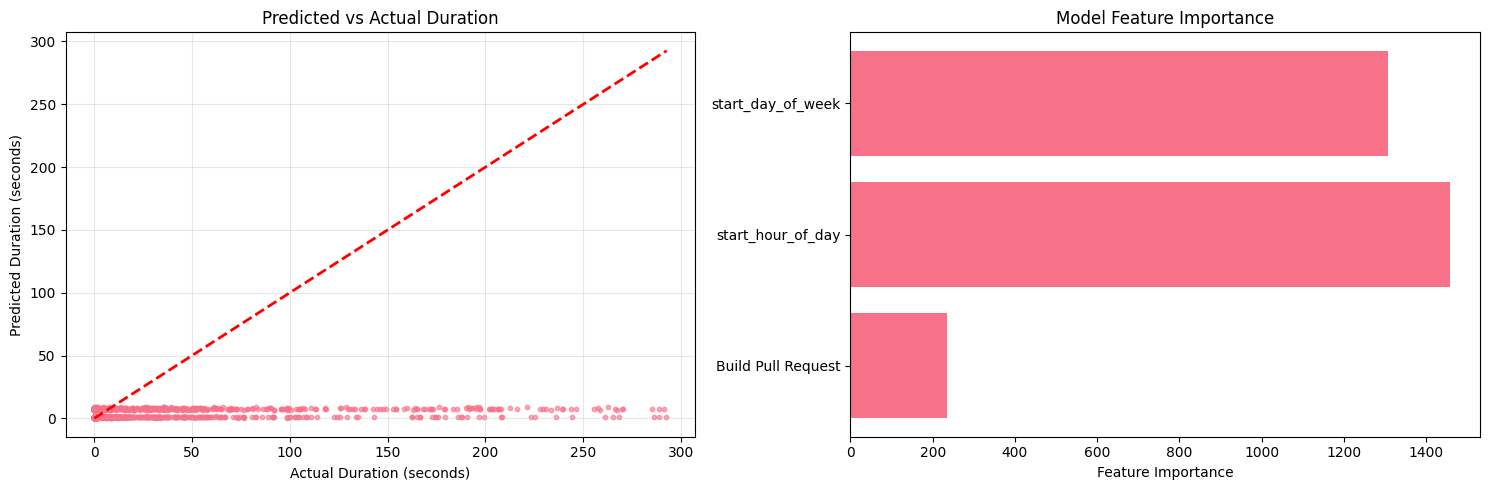

In [10]:
# Visualize model performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Predicted vs Actual scatter plot (sample for better visualization)
sample_size = min(5000, len(y_test_original))
sample_indices = np.random.choice(len(y_test_original), sample_size, replace=False)

ax1.scatter(y_test_original.iloc[sample_indices], y_pred_original[sample_indices], 
           alpha=0.6, s=10)
ax1.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Duration (seconds)')
ax1.set_ylabel('Predicted Duration (seconds)')
ax1.set_title('Predicted vs Actual Duration')
ax1.grid(True, alpha=0.3)

# Feature importance
importance = model.feature_importances_
feature_names = feature_columns
ax2.barh(feature_names, importance)
ax2.set_xlabel('Feature Importance')
ax2.set_title('Model Feature Importance')

plt.tight_layout()
plt.show()


In [11]:
## 6. Model Testing with Examples
#Let's test our model with some realistic scenarios.

# Define a prediction function
def predict_duration(is_pull_request, hour_of_day, day_of_week):
    """Predict pipeline duration for given parameters"""
    input_data = pd.DataFrame({
        'Build Pull Request': [is_pull_request],
        'start_hour_of_day': [hour_of_day],
        'start_day_of_week': [day_of_week]
    })
    
    prediction_log = model.predict(input_data)[0]
    prediction_seconds = np.expm1(prediction_log)
    
    return prediction_seconds

# Test different scenarios
test_scenarios = [
    {"name": "PR build, Monday morning (9 AM)", "is_pr": True, "hour": 9, "day": 0},
    {"name": "Regular build, Monday morning (9 AM)", "is_pr": False, "hour": 9, "day": 0},
    {"name": "PR build, Friday afternoon (3 PM)", "is_pr": True, "hour": 15, "day": 4},
    {"name": "Regular build, Weekend (Saturday 2 PM)", "is_pr": False, "hour": 14, "day": 5}
]

print("=== Prediction Examples ===")
for scenario in test_scenarios:
    duration = predict_duration(scenario["is_pr"], scenario["hour"], scenario["day"])
    print(f"{scenario['name']:35} → {duration:.1f}s ({duration/60:.1f} min)")


=== Prediction Examples ===
PR build, Monday morning (9 AM)     → 7.2s (0.1 min)
Regular build, Monday morning (9 AM) → 0.7s (0.0 min)
PR build, Friday afternoon (3 PM)   → 7.1s (0.1 min)
Regular build, Weekend (Saturday 2 PM) → 1.1s (0.0 min)


In [12]:
## 7. Export Model and Data
# Finally, we'll save our trained model and prepare data for the web dashboard.

# Export the trained model
model_filename = 'pipeline_duration_model_v2.pkl'
joblib.dump(model, model_filename)
print(f"Model saved as: {model_filename}")

# Save model metadata
model_info = {
    'features': feature_columns,
    'target': target_column,
    'categorical_features': [],
    'model_version': 'v2',
    'performance': {
        'mae_seconds': float(mae),
        'r2_score': float(r2)
    },
    'description': 'LightGBM model for predicting CI/CD pipeline durations'
}

info_filename = 'model_info_v2.json'
with open(info_filename, 'w') as f:
    json.dump(model_info, f, indent=2)
print(f"Model info saved as: {info_filename}")


Model saved as: pipeline_duration_model_v2.pkl
Model info saved as: model_info_v2.json


In [13]:
# Prepare dashboard data
print("Preparing data for dashboard...")

# Add predictions to the dataset
model_data['predicted_duration'] = np.expm1(model.predict(model_data[feature_columns]))

# Select relevant columns for dashboard
dashboard_columns = [
    'Test Suite Start Time', 'Test Suite', 'Test Suite Duration',
    'predicted_duration', 'Build Pull Request', 'start_hour_of_day', 'start_day_of_week'
]

dashboard_data = model_data[dashboard_columns].copy()

# Sample data to keep file size manageable
max_dashboard_rows = 20000
if len(dashboard_data) > max_dashboard_rows:
    dashboard_data = dashboard_data.sample(n=max_dashboard_rows, random_state=42)

# Export dashboard data
dashboard_filename = 'dashboard_data.csv'
dashboard_data.to_csv(dashboard_filename, index=False)
print(f"Dashboard data saved as: {dashboard_filename} ({len(dashboard_data):,} rows)")

print("\n=== Export Complete ===")
print(f"✓ Model: {model_filename}")
print(f"✓ Model info: {info_filename}")
print(f"✓ Dashboard data: {dashboard_filename}")


Preparing data for dashboard...
Dashboard data saved as: dashboard_data.csv (20,000 rows)

=== Export Complete ===
✓ Model: pipeline_duration_model_v2.pkl
✓ Model info: model_info_v2.json
✓ Dashboard data: dashboard_data.csv
